In [1]:
#fastai study group.  learning to do a competition in Kaggle.
#my code compilation

#11/22/2020 Compile clean draft, based on fastai-2020 study course
#     make it work like 09-tabular
#     no bells no whistles
#    simple: merge features & targets, get lr min recommendation, learn and relearn.
#     expect a score ~.02025

#11/28/2020 Add cross-validation, multilable stratified k-fold
#     from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 
#     src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
#
#     $note tried sklearn 
#     https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
#     UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.

#11/29/2020 Set initial lr
#     lr =.001 or determine dynamically in 0th fold
#     expect similar score ~.01972, got .01987 ok
#     misc edits: tried y_range=(0,1) but then train_loss and valid_loss are same everywhere

#11/29/2020 Set initial lr dynamically, don't train on controls
#     expect similar score ~range (.01972,.01987)


#next: params grid, cross-validation
#next: incorporate non-scoredMultilabelStratifiedKFold

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [3]:
#modeling
from fastai.tabular.all import *


In [4]:
#cross-validation
from ml_stratifiers import MultilabelStratifiedKFold

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [5]:
#src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
def make_folds(folds = 5, random_state = 0, stratify = True, scored = None):
    
    drug = pd.read_csv('../input/lish-moa/train_drug.csv')
    if scored is None:
        scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left')

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc<=18].index.sort_values()
    vc2 = vc.loc[vc>18].index.sort_values()

    # STRATIFY DRUGS 18 OR LESS
    dct1 = {}; dct2 = {}
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)
    
    # STRATIFY DRUGS MORE THAN 18
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)
    
    # ASSIGN FOLDS
    scored['fold'] = np.nan
    scored['fold'] = scored.drug_id.map(dct1)
    scored.loc[scored.fold.isna(),'fold'] = scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
    scored.fold = scored.fold.astype('int8')
    
    return scored[['sig_id','fold']].copy()

## 0. Load Data

In [6]:
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/train_targets_scored.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/test_features.csv')]

In [7]:
train_drug = pd.read_csv(path/'train_drug.csv')

print('train drug data\n', train_drug.shape)
display(train_drug.head(3))
train_drug.describe()

train drug data
 (23814, 2)


,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_2d3c6f198,cacb2b860
freq,1,1866


In [8]:
train_drug['drug_id'].value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
573c787a2       1
ddb7e0c01       1
ef4e67d99       1
f0d1b8dbc       1
209a68d23       1
Name: drug_id, Length: 3289, dtype: int64

In [9]:
train_features = pd.read_csv(path/'train_features.csv')
train_targets_scored = pd.read_csv(path/'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(path/'train_targets_nonscored.csv')
test_features = pd.read_csv(path/'test_features.csv')


In [10]:
print('train features', train_features.shape)
print('train targets', train_targets_scored.shape)
print('test features', test_features.shape)

display(train_features.head(3))
display(train_targets_scored.head(3))

train features (23814, 876)
train targets (23814, 207)
test features (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 0.1 EDA

In [11]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [12]:
train_features.groupby(['cp_type', 'cp_time', 'cp_dose'])[['sig_id']].count(), test_features.groupby(['cp_type', 'cp_time', 'cp_dose'])[['sig_id']].count()

(                             sig_id
 cp_type     cp_time cp_dose        
 ctl_vehicle 24      D1          301
                     D2          305
             48      D1          343
                     D2          305
             72      D1          307
                     D2          305
 trt_cp      24      D1         3585
                     D2         3581
             48      D1         4011
                     D2         3591
             72      D1         3600
                     D2         3580,
                              sig_id
 cp_type     cp_time cp_dose        
 ctl_vehicle 24      D1           58
                     D2           58
             48      D1           65
                     D2           59
             72      D1           59
                     D2           59
 trt_cp      24      D1          590
                     D2          594
             48      D1          660
                     D2          593
             72      D1          595


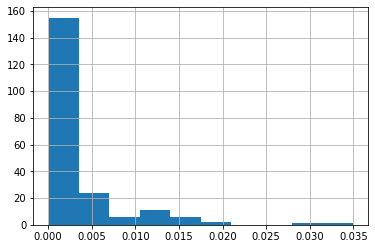

In [13]:
train_targets_scored.iloc[1:].mean().hist()

In [14]:
train_target_distrib = dict(train_targets_scored.iloc[:,1:].sum())
train_target_distrib

{'5-alpha_reductase_inhibitor': 17,
 '11-beta-hsd1_inhibitor': 18,
 'acat_inhibitor': 24,
 'acetylcholine_receptor_agonist': 190,
 'acetylcholine_receptor_antagonist': 301,
 'acetylcholinesterase_inhibitor': 73,
 'adenosine_receptor_agonist': 54,
 'adenosine_receptor_antagonist': 96,
 'adenylyl_cyclase_activator': 12,
 'adrenergic_receptor_agonist': 270,
 'adrenergic_receptor_antagonist': 360,
 'akt_inhibitor': 66,
 'aldehyde_dehydrogenase_inhibitor': 7,
 'alk_inhibitor': 42,
 'ampk_activator': 12,
 'analgesic': 12,
 'androgen_receptor_agonist': 48,
 'androgen_receptor_antagonist': 89,
 'anesthetic_-_local': 80,
 'angiogenesis_inhibitor': 36,
 'angiotensin_receptor_antagonist': 37,
 'anti-inflammatory': 73,
 'antiarrhythmic': 6,
 'antibiotic': 43,
 'anticonvulsant': 12,
 'antifungal': 13,
 'antihistamine': 12,
 'antimalarial': 18,
 'antioxidant': 73,
 'antiprotozoal': 36,
 'antiviral': 23,
 'apoptosis_stimulant': 49,
 'aromatase_inhibitor': 47,
 'atm_kinase_inhibitor': 6,
 'atp-sensiti

In [15]:
[(k,train_target_distrib[k]) for k in train_target_distrib if train_target_distrib[k] == 1]

[('atp-sensitive_potassium_channel_antagonist', 1), ('erbb2_inhibitor', 1)]

In [16]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.shape

(3982, 207)

## 1. Data Prep

##### Stratified k-folds
Create X & y  
Note: here y is only used for creating k-folds

In [17]:
X_train = train_features.merge(train_targets_scored,on='sig_id',how='left')
print(X_train.shape)

#drop records with no MoAs
X_train = X_train[X_train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
print(X_train.shape)

(23814, 1082)
(21948, 1082)


In [18]:
y_train = X_train[train_targets_scored.columns]
X_train.shape, y_train.shape


((21948, 1082), (21948, 207))

In [19]:
#crossvalidation with stratified k-fold
FOLDS = 10; SEED = 24
skf = make_folds(folds=FOLDS, random_state=SEED, stratify=True, scored=y_train)

X_train['kfold'] = skf.fold.values
X_train.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,4
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,9
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,9
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,7


##### TabularPandas and TabularProc

TabularPandas needs to be told which columns are continuous and which are categorical.  
Note: can handle that automatically using the helper function cont_cat_split (not used here).

In [20]:
#handpick 
cat_names = L(list(train_features.columns[1:4]))
cont_names = L(list(train_features.columns[4:]))
cat_names, cont_names

((#3) ['cp_type','cp_time','cp_dose'],
 (#872) ['g-0','g-1','g-2','g-3','g-4','g-5','g-6','g-7','g-8','g-9'...])

In [21]:
#define target vars
dep_var = list(train_targets_scored.columns[1:])
dep_var[:10]


['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist']

## 2. Model

Define dls

In [22]:
procs = [FillMissing, Categorify, Normalize]
def get_data(fold):
    val_idx = X_train[X_train['kfold']==fold].index
    #print(val_idx.shape)
    dls = TabularDataLoaders.from_df(X_train, path=path, y_names=dep_var,
                                        cat_names = cat_names,
                                        cont_names = cont_names,
                                        procs = procs,
                                        valid_idx=val_idx,
                                        bs=64)
    return dls #class fastai.tabular.data.TabularDataLoaders

Train k-folds

0 None


0.0017


epoch,train_loss,valid_loss,time
0,0.024771,0.020119,00:04
1,0.018353,0.018407,00:04
2,0.016591,0.018198,00:04
3,0.014270,0.018510,00:05
4,0.011455,0.019374,00:05
5,0.008511,0.020411,00:05
6,0.006015,0.021229,00:04
7,0.004961,0.021390,00:04


Better model found at epoch 0 with valid_loss value: 0.02011880837380886.
Better model found at epoch 1 with valid_loss value: 0.018407372757792473.
Better model found at epoch 2 with valid_loss value: 0.018197888508439064.


epoch,train_loss,valid_loss,time
0,0.013389,0.017603,00:04
1,0.012974,0.017539,00:04
2,0.012543,0.017555,00:04
3,0.011961,0.017582,00:04
4,0.012122,0.017626,00:05


Better model found at epoch 0 with valid_loss value: 0.017603445798158646.
Better model found at epoch 1 with valid_loss value: 0.017538679763674736.


epoch,train_loss,valid_loss,time
0,0.012771,0.017558,00:04
1,0.012404,0.017554,00:04
2,0.012718,0.017546,00:05
3,0.012634,0.017548,00:05
4,0.012586,0.017534,00:04


Better model found at epoch 0 with valid_loss value: 0.017557615414261818.
Better model found at epoch 1 with valid_loss value: 0.017553778365254402.
Better model found at epoch 2 with valid_loss value: 0.017546245828270912.
Better model found at epoch 4 with valid_loss value: 0.017534324899315834.
1 0.0017


epoch,train_loss,valid_loss,time
0,0.024513,0.020461,00:04
1,0.018374,0.019133,00:04
2,0.016556,0.018925,00:04
3,0.014232,0.019288,00:04
4,0.011673,0.020225,00:04
5,0.008350,0.021283,00:05
6,0.005980,0.022073,00:04
7,0.004891,0.022350,00:05


Better model found at epoch 0 with valid_loss value: 0.020460767671465874.
Better model found at epoch 1 with valid_loss value: 0.01913280226290226.
Better model found at epoch 2 with valid_loss value: 0.018924739211797714.


epoch,train_loss,valid_loss,time
0,0.013414,0.018406,00:04
1,0.012657,0.018349,00:04
2,0.012503,0.018406,00:04
3,0.012037,0.018438,00:05
4,0.012087,0.018472,00:04


Better model found at epoch 0 with valid_loss value: 0.018405819311738014.
Better model found at epoch 1 with valid_loss value: 0.018348611891269684.


epoch,train_loss,valid_loss,time
0,0.012581,0.018372,00:04
1,0.012665,0.018371,00:04
2,0.012128,0.018406,00:04
3,0.012548,0.018383,00:04
4,0.012315,0.018398,00:04


Better model found at epoch 0 with valid_loss value: 0.018372248858213425.
Better model found at epoch 1 with valid_loss value: 0.018370868638157845.
2 0.0017


epoch,train_loss,valid_loss,time
0,0.024744,0.020188,00:05
1,0.018324,0.018774,00:04
2,0.016398,0.017920,00:04
3,0.014426,0.018232,00:04
4,0.011490,0.019111,00:05
5,0.008738,0.020125,00:04
6,0.006339,0.020799,00:04
7,0.005165,0.020939,00:04


Better model found at epoch 0 with valid_loss value: 0.02018788643181324.
Better model found at epoch 1 with valid_loss value: 0.018773552030324936.
Better model found at epoch 2 with valid_loss value: 0.017920181155204773.


epoch,train_loss,valid_loss,time
0,0.013624,0.017582,00:04
1,0.013357,0.017593,00:04
2,0.012648,0.017603,00:04
3,0.012340,0.017644,00:05
4,0.012353,0.017658,00:05


Better model found at epoch 0 with valid_loss value: 0.017582105472683907.


epoch,train_loss,valid_loss,time
0,0.013337,0.017573,00:04
1,0.013195,0.017542,00:04
2,0.013204,0.017568,00:04
3,0.013129,0.017539,00:04
4,0.012948,0.017559,00:04


Better model found at epoch 0 with valid_loss value: 0.017573295161128044.
Better model found at epoch 1 with valid_loss value: 0.01754162833094597.
Better model found at epoch 3 with valid_loss value: 0.017539193853735924.
3 0.0017


epoch,train_loss,valid_loss,time
0,0.024928,0.020519,00:05
1,0.018750,0.018838,00:04
2,0.016136,0.018646,00:04
3,0.013844,0.019010,00:05
4,0.011459,0.019811,00:05
5,0.008247,0.021256,00:04
6,0.006042,0.022130,00:04
7,0.004771,0.022293,00:04


Better model found at epoch 0 with valid_loss value: 0.020519087091088295.
Better model found at epoch 1 with valid_loss value: 0.018838368356227875.
Better model found at epoch 2 with valid_loss value: 0.01864645443856716.


epoch,train_loss,valid_loss,time
0,0.013388,0.018156,00:04
1,0.013049,0.018217,00:04
2,0.012300,0.018264,00:04
3,0.012028,0.018303,00:05
4,0.012010,0.018321,00:04


Better model found at epoch 0 with valid_loss value: 0.018155595287680626.


epoch,train_loss,valid_loss,time
0,0.013153,0.018148,00:04
1,0.012977,0.018142,00:04
2,0.012978,0.018143,00:04
3,0.012890,0.018161,00:05
4,0.012877,0.018167,00:04


Better model found at epoch 0 with valid_loss value: 0.018148155882954597.
Better model found at epoch 1 with valid_loss value: 0.018141502514481544.
4 0.0017


epoch,train_loss,valid_loss,time
0,0.024583,0.021199,00:05
1,0.018483,0.019674,00:04
2,0.016608,0.019306,00:04
3,0.014347,0.019698,00:04
4,0.011340,0.020557,00:05
5,0.008557,0.021282,00:04
6,0.006156,0.021937,00:04
7,0.005025,0.022124,00:05


Better model found at epoch 0 with valid_loss value: 0.021199384704232216.
Better model found at epoch 1 with valid_loss value: 0.01967402547597885.
Better model found at epoch 2 with valid_loss value: 0.01930611953139305.


epoch,train_loss,valid_loss,time
0,0.013627,0.018579,00:05
1,0.012957,0.018559,00:05
2,0.012619,0.018565,00:04
3,0.012171,0.018649,00:05
4,0.011986,0.018680,00:04


Better model found at epoch 0 with valid_loss value: 0.01857880689203739.
Better model found at epoch 1 with valid_loss value: 0.018559325486421585.


epoch,train_loss,valid_loss,time
0,0.012622,0.018539,00:04
1,0.012457,0.018675,00:04
2,0.012595,0.018610,00:04
3,0.012566,0.018581,00:04
4,0.012370,0.018554,00:05


Better model found at epoch 0 with valid_loss value: 0.018539413809776306.
5 0.0017


epoch,train_loss,valid_loss,time
0,0.025141,0.019454,00:05
1,0.018528,0.017642,00:05
2,0.016682,0.017453,00:04
3,0.014349,0.017745,00:05
4,0.011753,0.018440,00:04
5,0.008538,0.019831,00:04
6,0.006215,0.020595,00:04
7,0.005202,0.020679,00:04


Better model found at epoch 0 with valid_loss value: 0.019454224035143852.
Better model found at epoch 1 with valid_loss value: 0.017642280086874962.
Better model found at epoch 2 with valid_loss value: 0.017453087493777275.


epoch,train_loss,valid_loss,time
0,0.013488,0.016977,00:04
1,0.013171,0.016898,00:04
2,0.012663,0.016985,00:05
3,0.012709,0.017010,00:05
4,0.012172,0.017023,00:05


Better model found at epoch 0 with valid_loss value: 0.016977226361632347.
Better model found at epoch 1 with valid_loss value: 0.016898328438401222.


epoch,train_loss,valid_loss,time
0,0.012505,0.016907,00:04
1,0.012692,0.016924,00:04
2,0.012631,0.016942,00:04
3,0.012590,0.016929,00:05
4,0.012732,0.016943,00:05


Better model found at epoch 0 with valid_loss value: 0.016906755045056343.
6 0.0017


epoch,train_loss,valid_loss,time
0,0.024948,0.020320,00:04
1,0.018507,0.018213,00:04
2,0.016596,0.018273,00:05
3,0.014180,0.018312,00:05
4,0.011440,0.019307,00:04
5,0.008390,0.020414,00:04
6,0.006061,0.021237,00:04
7,0.004917,0.021422,00:04


Better model found at epoch 0 with valid_loss value: 0.020320143550634384.
Better model found at epoch 1 with valid_loss value: 0.018212713301181793.


epoch,train_loss,valid_loss,time
0,0.015993,0.017423,00:04
1,0.015614,0.017250,00:05
2,0.015229,0.017200,00:04
3,0.014829,0.017194,00:04
4,0.014976,0.017196,00:04


Better model found at epoch 0 with valid_loss value: 0.017422782257199287.
Better model found at epoch 1 with valid_loss value: 0.017250273376703262.
Better model found at epoch 2 with valid_loss value: 0.017200328409671783.
Better model found at epoch 3 with valid_loss value: 0.017194021493196487.


epoch,train_loss,valid_loss,time
0,0.014635,0.017186,00:04
1,0.014710,0.017182,00:05
2,0.014641,0.017193,00:05
3,0.014533,0.017183,00:05
4,0.014589,0.017181,00:04


Better model found at epoch 0 with valid_loss value: 0.017186209559440613.
Better model found at epoch 1 with valid_loss value: 0.017181986942887306.
Better model found at epoch 4 with valid_loss value: 0.017181234434247017.
7 0.0017


epoch,train_loss,valid_loss,time
0,0.025362,0.020151,00:04
1,0.018553,0.018939,00:05
2,0.016531,0.018328,00:04
3,0.014426,0.018981,00:04
4,0.011399,0.019505,00:04
5,0.008518,0.021052,00:05
6,0.005977,0.021808,00:05
7,0.004983,0.022047,00:05


Better model found at epoch 0 with valid_loss value: 0.020150640979409218.
Better model found at epoch 1 with valid_loss value: 0.0189391877502203.
Better model found at epoch 2 with valid_loss value: 0.018327785655856133.


epoch,train_loss,valid_loss,time
0,0.013546,0.017913,00:05
1,0.012856,0.017949,00:04
2,0.012763,0.018034,00:04
3,0.012254,0.018060,00:04
4,0.011971,0.018053,00:04


Better model found at epoch 0 with valid_loss value: 0.01791270636022091.


epoch,train_loss,valid_loss,time
0,0.013029,0.017917,00:04
1,0.012990,0.017921,00:05
2,0.012979,0.017922,00:04
3,0.013010,0.017906,00:04
4,0.013126,0.017927,00:04


Better model found at epoch 0 with valid_loss value: 0.017917122691869736.
Better model found at epoch 3 with valid_loss value: 0.017905620858073235.
8 0.0017


epoch,train_loss,valid_loss,time
0,0.024906,0.020166,00:05
1,0.018874,0.018711,00:04
2,0.016814,0.018613,00:04
3,0.014261,0.018623,00:04
4,0.011286,0.019729,00:04
5,0.008391,0.021029,00:04
6,0.006110,0.021831,00:04
7,0.004910,0.021926,00:05


Better model found at epoch 0 with valid_loss value: 0.02016596496105194.
Better model found at epoch 1 with valid_loss value: 0.018710561096668243.
Better model found at epoch 2 with valid_loss value: 0.018613453954458237.


epoch,train_loss,valid_loss,time
0,0.013535,0.018004,00:04
1,0.012881,0.018054,00:04
2,0.012354,0.018101,00:05
3,0.012431,0.018194,00:05
4,0.012046,0.018179,00:04


Better model found at epoch 0 with valid_loss value: 0.018003514036536217.


epoch,train_loss,valid_loss,time
0,0.013255,0.017948,00:05
1,0.013060,0.017982,00:04
2,0.013359,0.018007,00:04
3,0.013003,0.017925,00:04
4,0.013019,0.017989,00:04


Better model found at epoch 0 with valid_loss value: 0.017948152497410774.
Better model found at epoch 3 with valid_loss value: 0.017925051972270012.
9 0.0017


epoch,train_loss,valid_loss,time
0,0.024941,0.020347,00:05
1,0.018411,0.019032,00:04
2,0.016118,0.018684,00:05
3,0.013879,0.019274,00:04
4,0.011341,0.020190,00:04
5,0.008428,0.021354,00:04
6,0.005957,0.022210,00:05
7,0.004888,0.022373,00:04


Better model found at epoch 0 with valid_loss value: 0.020347127690911293.
Better model found at epoch 1 with valid_loss value: 0.019032087177038193.
Better model found at epoch 2 with valid_loss value: 0.018684353679418564.


epoch,train_loss,valid_loss,time
0,0.013461,0.018298,00:04
1,0.012789,0.018236,00:04
2,0.012626,0.018267,00:04
3,0.012298,0.018363,00:04
4,0.012034,0.018330,00:04


Better model found at epoch 0 with valid_loss value: 0.01829824224114418.
Better model found at epoch 1 with valid_loss value: 0.01823611930012703.


epoch,train_loss,valid_loss,time
0,0.012668,0.018216,00:05
1,0.012524,0.018244,00:05
2,0.012300,0.018251,00:05
3,0.012274,0.018253,00:04
4,0.012539,0.018236,00:04


Better model found at epoch 0 with valid_loss value: 0.018216298893094063.


[0.017534324899315834,
 0.018370868638157845,
 0.017539193853735924,
 0.018141502514481544,
 0.018539413809776306,
 0.016906755045056343,
 0.017181234434247017,
 0.017905620858073235,
 0.017925051972270012,
 0.018216298893094063]

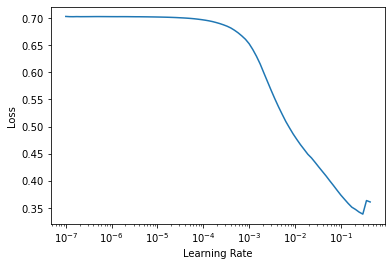

In [23]:
torch.cuda.empty_cache() 
best_valid = []
lr = None

for i in range(FOLDS):
    print(i, lr)
    dls = get_data(i) # Data
    #len(dls.train),len(dls.valid)
    #dls.show(5)
    
    #setup learner
    learn = tabular_learner(dls, layers=[512,512], loss_func=BCEWithLogitsLossFlat(), model_dir='/kaggle/working/')

    if i==0:       
        #set learning rate once
        lr1, lr2 = learn.lr_find()
        lr = round(lr2, 4)
        print(lr)

    name = 'best_model_' + str(i) 
    cb = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks

    #train
    learn.fit_one_cycle(8, slice(lr), cbs=cb)
    #load best model
    learn.load(name) 

    cb1 = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks
    learn.unfreeze()
    learn.fit_one_cycle(5,slice(1e-4),wd=0.2,cbs=cb1)
    #load best model
    learn.load(name) 

    cb2 = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5),wd=0.25,cbs=cb2)
    #load best model
    learn.load(name)

    losses = np.array(learn.recorder.values)
    best = np.argmin(losses[:,1])
    best_valid.append(losses[best,1])

    #export model
    learn.export('/kaggle/working/'+name+'.pkl') 
    
best_valid
    

In [24]:
best_valid

[0.017534324899315834,
 0.018370868638157845,
 0.017539193853735924,
 0.018141502514481544,
 0.018539413809776306,
 0.016906755045056343,
 0.017181234434247017,
 0.017905620858073235,
 0.017925051972270012,
 0.018216298893094063]

## 3. Predict

In [25]:
modelspath = Path("/kaggle/working/")

In [26]:
fold_preds = []
for i in range(FOLDS):
    learner = load_learner(modelspath/f'best_model_{i}.pkl')
    test_dl = learner.dls.test_dl(test_features)
    preds, _ = learner.get_preds(dl=test_dl)
    fold_preds += [preds]
preds = torch.stack(fold_preds)


In [27]:
mean_preds = preds.mean(0)
mean_preds[0]

tensor([3.6244e-04, 6.8095e-04, 1.2182e-03, 1.6521e-02, 1.9650e-02, 2.2652e-03,
        1.4321e-03, 4.0662e-03, 8.0712e-05, 8.3329e-03, 1.4453e-02, 3.8799e-04,
        7.7596e-05, 1.1128e-04, 3.9676e-04, 2.6449e-04, 1.3484e-03, 4.1596e-03,
        1.0762e-02, 1.8166e-03, 2.5338e-03, 2.5172e-03, 1.1096e-04, 9.3104e-04,
        2.9306e-04, 1.5872e-04, 6.8266e-04, 2.1339e-04, 3.9424e-03, 1.3507e-03,
        7.5052e-04, 2.7312e-03, 2.7660e-03, 5.7649e-05, 6.6072e-05, 4.1530e-05,
        2.4656e-03, 1.0634e-04, 7.2509e-04, 1.5770e-04, 2.6122e-03, 5.6623e-03,
        6.9294e-04, 6.3215e-03, 6.5414e-03, 9.7735e-03, 4.2167e-05, 2.2983e-03,
        4.0340e-04, 2.0809e-03, 9.2073e-04, 1.9105e-03, 1.5888e-04, 2.3736e-04,
        1.4076e-02, 9.1516e-04, 1.1752e-03, 1.2812e-03, 6.7305e-04, 1.3272e-03,
        5.8271e-04, 6.9345e-03, 6.0564e-04, 3.1091e-04, 1.8042e-03, 3.6165e-05,
        1.2804e-03, 3.8254e-03, 2.5293e-03, 1.5776e-04, 3.1191e-04, 4.6281e-02,
        2.8532e-03, 4.3715e-04, 1.2159e-

In [28]:
submission = sub.copy()
submission[dep_var] = mean_preds
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0
submission['atp-sensitive_potassium_channel_antagonist'] = 0 # only appears once
submission['erbb2_inhibitor'] = 0 # only appears once

In [29]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000362,0.000681,0.001218,0.016521,0.019650,0.002265,0.001432,0.004066,0.000081,...,0.000343,0.001154,0.002294,0.001664,0.000249,0.000233,0.000306,0.001434,0.004639,0.001098
1,id_001897cda,0.000049,0.000387,0.001081,0.001312,0.001368,0.002512,0.001384,0.018444,0.009427,...,0.000162,0.000808,0.001596,0.000127,0.021093,0.000201,0.008312,0.000299,0.003610,0.002035
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000064,0.000188,0.002171,0.013520,0.005562,0.003337,0.001148,0.003926,0.000223,...,0.000312,0.000509,0.003432,0.018181,0.007869,0.000121,0.001121,0.001245,0.001934,0.003478
4,id_0027f1083,0.001634,0.001084,0.001487,0.018597,0.021649,0.003044,0.008049,0.002655,0.000258,...,0.000521,0.000717,0.006782,0.003525,0.001085,0.000587,0.001360,0.002210,0.000376,0.001592


In [30]:
submission.to_csv('submission.csv', index=False)

In [31]:
''' $xtra manual train/valid split
was manually split, replaced with k-fold
#temp split manually
#define train vs valid split
n_train = int(train_features.shape[0] *.8)

split_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])
train_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]
splits = (list(train_idx), list(valid_idx))

#preview
len(splits[0]), len(splits[1])

'''

' $xtra manual train/valid split\nwas manually split, replaced with k-fold\n#temp split manually\n#define train vs valid split\nn_train = int(train_features.shape[0] *.8)\n\nsplit_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])\ntrain_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]\nsplits = (list(train_idx), list(valid_idx))\n\n#preview\nlen(splits[0]), len(splits[1])\n\n'